In [4]:
import pandas as pd
d = pd.read_csv("train.csv",lineterminator='\n')
import numpy as np
d.label = np.array(d.label == "Positive",dtype = 'float')
d.isnull().sum()

ID        0
review    0
label     6
dtype: int64


In [2]:
from sklearn.model_selection import train_test_split
xd_train,xd_test,yd_train,yd_test = train_test_split(d.review,d.label,random_state = 10)

In [3]:
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
def performance(y_true,pred,color='r',ann=True):
    acc = accuracy_score(y_true,pred[:,1]>0.5)
    auc = roc_auc_score(y_true,pred[:,1])
    fpr,tpr,thr = roc_curve(y_true,pred[:,1])
    plt.figure()
    plt.plot(fpr,tpr,color,linewidth = '1')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    if ann:
        plt.annotate('ACC:{:.2f}'.format(acc),(0.2,0.3),size=14)
        plt.annotate('AUC:{:.2f}'.format(auc),(0.2,0.2),size=14)

In [4]:
import re

emoticons_str = r"""
    (?:
        [:=;]   
        [oO\-]?  
        [D\)\]\(\]/\\OpP] 
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @某人
    r"(?:\#+[\w_]+[\w\'_\-]*[\w]+)",  # 话题标签
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # 数字
    r"(?:[a-z][a-z'\-_]+[a-z])",  # 含有- 和’ 的单词
    r'(?:[\w_]+)',  # 其他
    r'(?:\S)'  # 其他
]

tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re=re.compile(r'^'+emoticons_str+'$',re.VERBOSE|re.IGNORECASE)
def tokenize(s):
    return tokens_re.findall(s)
import string
def transform(X):
    ls = []
    punc = string.punctuation
    for review in X:
        tokens = tokenize(review)
        tokens_dict = {}
        for token in tokens:
#             if token in punc:
#                 continue
            token = token.lower()
            if token in tokens_dict.keys():
                token_num = tokens_dict[token]+1
            else:
                token_num = 1
            tokens_dict[token] = token_num
        ls.append(tokens_dict)
    return ls

In [5]:
from sklearn.feature_extraction import DictVectorizer
dict_vectorizer = DictVectorizer()
features = dict_vectorizer.fit_transform(transform(xd_train))
test_features = dict_vectorizer.transform(transform(xd_test))
features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

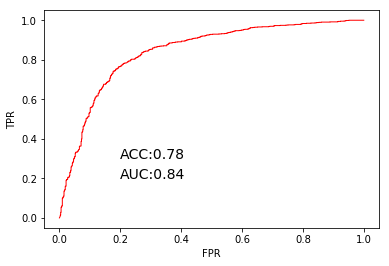

In [6]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB()
model1.fit(features,yd_train)
pred1 = model1.predict_proba(test_features)
performance(yd_test,pred1)

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
tfidf_features = transformer.fit_transform(features.toarray())
tfidf_test_features = transformer.transform(test_features.toarray())

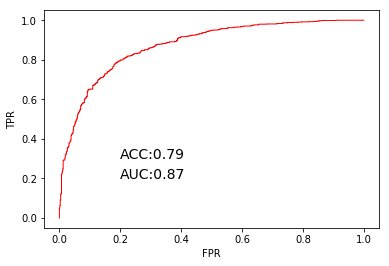

In [8]:
model1 = MultinomialNB()
model1.fit(tfidf_features,yd_train)
pred1 = model1.predict_proba(tfidf_test_features)
performance(yd_test,pred1)

In [ ]:
def build_model(nb_alpha=1.0):
    transformer = TfidfTransformer()
    tfidf_features = transformer.fit_transform(features.toarray())
    tfidf_test_features = transformer.transform(test_features.toarray())
    model2 = MultinomialNB(alpha=nb_alpha)
    model2.fit(tfidf_features,yd_train)
    pred2 = model2.predict_proba(tfidf_test_features)
    return {
        'nb_alpha':nb_alpha,
        'auc':roc_auc_score(yd_test,pred2[:,1])
    }

In [ ]:
from itertools import product
param_values = {
    'nb_alpha':[0.2,0.25,0.3,0.35,0.4,0.5]
}
results = []
for p in product(*param_values.values()):
    res = build_model(**dict(zip(param_values.keys(),p)))
    results.append(res)
    print(res)

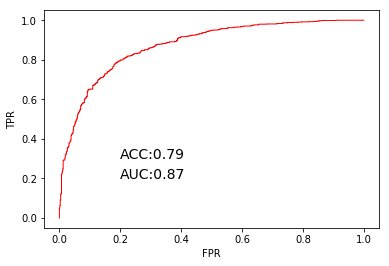

In [14]:
transformer = TfidfTransformer()
tfidf_features = transformer.fit_transform(dict_vectorizer.transform(transform(xd_train)))
tfidf_test_features = transformer.transform(dict_vectorizer.transform(transform(xd_test)))
model1 = MultinomialNB()
model1.fit(tfidf_features,yd_train)
pred1 = model1.predict_proba(tfidf_test_features)
performance(yd_test,pred1)

In [15]:
test = pd.read_csv("20190513_test.csv",lineterminator='\n')
pred = model1.predict_proba(dict_vectorizer.transform(transform(test.review)))
pred

array([[1.65861563e-04, 9.99834138e-01],
       [1.79625865e-02, 9.82037414e-01],
       [8.71579375e-04, 9.99128421e-01],
       ...,
       [1.17304721e-01, 8.82695279e-01],
       [6.67706642e-01, 3.32293358e-01],
       [3.59264975e-01, 6.40735025e-01]])

/home/yang/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


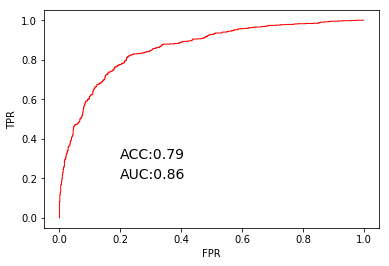

In [16]:
from sklearn.linear_model import LogisticRegression
model5 = LogisticRegression()
model5.fit(tfidf_features,yd_train)
pred5 = model5.predict_proba(tfidf_test_features)
performance(yd_test,pred5)

In [ ]:
data = {'ID':np.array(test.ID),'Pred':pred[:,1]}
pd.DataFrame(data, columns=['ID', 'Pred']).to_csv('test_pred.csv', header=True)

In [ ]:
from gensim.models.word2vec import Word2Vec

In [ ]:
sentences = transform(["Tc ? Apky mun xe exe alfax achy nae lgty 😒💃"])
model = Word2Vec(sentences,size=300,window=10,min_count=1,sample=1e-3,workers=2)
model.init_sims(replace=True)
print(model[''])
sentences

In [ ]:
def featurize_w2v(model,sentences):
    f = np.zeros((len(sentences),model.vector_size))
    for i,s in enumerate(sentences):
        for w in s:
            try:
                vec = model[w]
            except KeyError:
                continue
            f[i,:] = f[i,:]+vec
        f[i,:] = f[i,:]/len(s)
    return f

In [ ]:
sentences = transform(xd_train)
model = Word2Vec(sentences)
model.init_sims(replace=True)
features_w2v = featurize_w2v(model,[x.keys()for x in sentences])
for x in sentences:
    print(x.keys())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier(n_estimators=100,n_jobs=-1)
model4.fit(features_w2v,yd_train)

In [ ]:
test_sentences = transform(xd_test)
test_features_w2v = featurize_w2v(model , [x.keys()for x in test_sentences])
pred4 = model4.predict_proba(test_features_w2v)
performance(yd_test,pred4)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model5 = LogisticRegression()
model5.fit(features_w2v,yd_train)
pred5 = model5.predict_proba(test_features_w2v)
performance(yd_test,pred5)